
# Satire Detection: Exploratory Data Analysis (EDA)

This notebook provides a comprehensive Exploratory Data Analysis (EDA) on a dataset of satirical and non-satirical articles.


# Installs and Imports

In [2]:
# import true dataset
!pip install datasets

  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/09/7e/fd4d6441a541dba61d0acb3c1fd5df53214c2e9033854e837a99dd9e0793/datasets-2.14.5-py3-none-any.whl.metadata
  Obtaining dependency information for xxhash from https://files.pythonhosted.org/packages/80/8a/1dd41557883b6196f8f092011a5c1f72d4d44cf36d7b67d4a5efe3127949/xxhash-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for huggingface-hub<1.0.0,>=0.14.0 from https://files.pythonhosted.org/packages/ef/b5/b6107bd65fa4c96fdf00e4733e2fe5729bb9e5e09997f63074bb43d3ab28/huggingface_hub-0.18.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.4 MB/s eta 0:00:00ta 0:00:01


In [3]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/22/0d/bb4eccd60d272b33cbc79c661c60acc604f1688cfc922deb9d3eb5be640a/wordcloud-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 11.1 MB/s eta 0:00:0000:01


In [4]:
import os
import re
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from wordcloud import WordCloud
import boto3
from datetime import datetime
from io import StringIO

# Load, Transform, Clean Data

In [13]:
# Set the S3 bucket and folder path
s3_bucket = 'satire-spotter-data'
s3_folder = 'satire'
s3_checkpoint_folder = 'checkpointed-full-datasets'

# Initialize S3 client
s3_client = boto3.client('s3')

In [15]:
# Define the local directory to store the S3 data
local_dir = '/home/ec2-user/SageMaker/satire_data'

# Create the local directory if it doesn't exist
if not os.path.exists(local_dir):
    os.makedirs(local_dir)

# Download the ZIP file from S3
s3_object_key = f'{s3_folder}/satire.zip'
local_zip_path = os.path.join(local_dir, 'satire.zip')
s3_client.download_file(s3_bucket, s3_object_key, local_zip_path)

# Extract the ZIP file
unzip_dir = os.path.join(local_dir, 'satire_unzipped')
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# Define paths
satire_dir = os.path.join(unzip_dir, 'satire')
training_path = os.path.join(satire_dir, 'training')
training_class_path = os.path.join(satire_dir, 'training-class')

# Load training labels
with open(training_class_path, 'r', encoding='utf-8', errors='ignore') as file:
    training_labels = [line.strip().split() for line in file.readlines()]

# Mapping of filenames to labels
label_map = {filename: label for filename, label in training_labels}

# Load training examples
training_data = []
for filename, label in training_labels:
    file_path = os.path.join(training_path, filename)
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()
        training_data.append({
            'filename': filename,
            'content': content,
            'label': label
        })

# Convert to DataFrame for easier analysis
training_df = pd.DataFrame(training_data)

# Load "The Onion" articles from S3
theonion_dir = os.path.join(satire_dir, 'theonion_articles')
theonion_data = []

# List objects in the S3 bucket folder
s3_theonion_objects = s3_client.list_objects_v2(Bucket=s3_bucket, Prefix=f'{s3_folder}/theonion_articles/')['Contents']

for s3_object in s3_theonion_objects:
    s3_object_key = s3_object['Key']
    filename = os.path.basename(s3_object_key)
    response = s3_client.get_object(Bucket=s3_bucket, Key=s3_object_key)
    content = response['Body'].read().decode('utf-8', errors='ignore')
    theonion_data.append({
        'filename': filename,
        'content': content,
        'label': 'satire'
    })

# Convert to DataFrame and append to the main training DataFrame
theonion_df = pd.DataFrame(theonion_data)
training_df_extended = pd.concat([training_df, theonion_df], ignore_index=True)
training_df_extended['word_count'] = training_df_extended['content'].apply(lambda x: len(x.split()))

In [16]:
training_df_extended.label.value_counts()

label
true      2505
satire     177
Name: count, dtype: int64

In [20]:
# Define the S3 object key for the allSatire.csv file
s3_object_key = f'{s3_folder}/allSatire.csv'

# Download the CSV file from S3
response = s3_client.get_object(Bucket=s3_bucket, Key=s3_object_key)
csv_data = response['Body'].read().decode('utf-8')

# Convert the CSV data to a DataFrame
df_hare = pd.read_csv(StringIO(csv_data), usecols=['Body', 'Title', 'wordCount'])

In [21]:
df_hare.head()

,Body,Title,wordCount
0,"WHITE PLAINS, KY—Reports coming out of United ...",Motion-Activated Lights Turn Off During Presby...,224
1,"Jamestown, RI—In a series of devastating tweet...",Biological Survival Machine Claims Twitter Vic...,314
2,"WEST LINN, OR—Local unemployed 28-year-old man...","‘Religion Is A Parasite,’ Says Guy Living In M...",215
3,"NASHVILLE, TN—After months of speculation and ...",LifeWay Introduces New Protective Christian Bu...,180
4,"NEWPORT, VT—Arrive at First Baptist Church of ...",Local Man With No Detectable Spiritual Gifts A...,279


In [22]:
def transform_df_hare(df):
    # Create filename column using f-strings
    df['filename'] = [f'hare_{i+1:05}' for i in range(df.shape[0])]

    # Remove everything before the first dash in the Body column
    df['Body'] = df['Body'].apply(lambda x: x.split('—', 1)[-1].strip())

    # Create a content column combining Title and Body using f-strings
    df['content'] = df.apply(lambda row: f"{row['Title']}\n{row['Body']}", axis=1)

    # Rename wordCount column to word_count
    df.rename(columns={"wordCount": "word_count"}, inplace=True)

    # Add label column with "satire" as default value
    df['label'] = 'satire'

    # Rearrange and select desired columns
    df = df[['filename', 'content', 'label', 'word_count']]

    return df

In [23]:
transformed_df_hare = transform_df_hare(df_hare)

In [24]:
transformed_df_hare.head()

,filename,content,label,word_count
0,hare_00001,Motion-Activated Lights Turn Off During Presby...,satire,224
1,hare_00002,Biological Survival Machine Claims Twitter Vic...,satire,314
2,hare_00003,"‘Religion Is A Parasite,’ Says Guy Living In M...",satire,215
3,hare_00004,LifeWay Introduces New Protective Christian Bu...,satire,180
4,hare_00005,Local Man With No Detectable Spiritual Gifts A...,satire,279


## Merging data frames

In [25]:
training_df_extended = pd.concat([training_df_extended, transformed_df_hare], ignore_index=True)

In [26]:
from datasets import load_dataset
true_dataset = load_dataset("cc_news", split='train')
true_df = true_dataset.to_pandas()

Generating train split:   0%|          | 0/708241 [00:00<?, ? examples/s]

In [27]:
true_df.text[0]

'There\'s a surprising twist to Regina Willoughby\'s last season with Columbia City Ballet: It\'s also her 18-year-old daughter Melina\'s first season with the company. Regina, 40, will retire from the stage in March, just as her daughter starts her own career as a trainee. But for this one season, they\'re sharing the stage together.\nPerforming Side-By-Side In The Nutcracker\nRegina and Melina are not only dancing in the same Nutcracker this month, they\'re onstage at the same time: Regina is doing Snow Queen, while Melina is in the snow corps, and they\'re both in the Arabian divertissement. "It\'s very surreal to be dancing it together," says Regina. "I don\'t know that I ever thought Melina would take ballet this far."\nLeft: Regina and Melina with another company member post-snow scene in 2003. Right: The pair post-snow scene in 2017 (in the same theater)\nKeep reading at dancemagazine.com.'

In [28]:
# Drop duplicate records, keeping the latest version of the article with the exact same title.
true_df.sort_values(by='date', ascending=True).drop_duplicates(subset=['title'], keep='last', inplace=True)

In [29]:
# def transform_true_df(df):
#     # Create filename column using f-strings
#     df['filename'] = [f'cc-news_{i+1:05}' for i in range(df.shape[0])]

#     # Create a content column combining Title and Body using f-strings
#     df['content'] = df.apply(lambda row: f"{row['title']}\n{row['text']}", axis=1)

#     def count_words(text):
#       words = text.split()
#       return len(words)

#     # Get a rough count of the words in the text, including title
#     df['word_count'] = df['content'].apply(count_words)

#     # Add label column with "satire" as default value
#     df['label'] = 'true'

#     # Rearrange and select desired columns
#     df = df[['filename', 'content', 'label', 'word_count']]

#     return df

## this updated version removes all of the urls
def transform_true_df(df):
    # Create filename column using f-strings
    df['filename'] = [f'cc-news_{i+1:05}' for i in range(df.shape[0])]

    # Create a content column combining Title and Body using f-strings
    df['content'] = df.apply(lambda row: f"{row['title']}\n{row['text']}", axis=1)

    # Function to remove URLs and month-year combinations
    def remove_urls_and_dates(text):
        # Regular expression pattern to match most URLs
        url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|www\.\S+')
        text = url_pattern.sub('', text)

        # Regular expression pattern to match month-year combinations (e.g., July 2018)
        date_pattern = re.compile(r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{4}\b', re.IGNORECASE)
        return date_pattern.sub('', text)

    # Apply the function to remove URLs and month-year combinations
    df['content'] = df['content'].apply(remove_urls_and_dates)

    def count_words(text):
      words = text.split()
      return len(words)

    # Get a rough count of the words in the text, including title
    df['word_count'] = df['content'].apply(count_words)

    # Add label column with "true" as default value
    df['label'] = 'true'

    # Rearrange and select desired columns
    df = df[['filename', 'content', 'label', 'word_count']]

    return df



In [30]:
# Selecting the top 20000 most recent records to save space on Colab
# n = 20000
# true_df_sorted = true_df.sort_values(by='date', ascending=False)
# top_20k = true_df_sorted.head(n)

# transformed_true_df = transform_true_df(top_20k)
# transformed_true_df.head()


# Using a random grouping of articles
n = 20000
random_20k = true_df.sample(n, random_state=42)  # `random_state` ensures reproducibility

transformed_true_df = transform_true_df(random_20k)
transformed_true_df.head()

,filename,content,label,word_count
526156,cc-news_00001,‘Indexpo’ in the city from June 16 to 18\nNash...,true,209
410807,cc-news_00002,Quit notice: We are monitoring situation in No...,true,476
300450,cc-news_00003,"Two teens charged, accused of leading police o...",true,168
182164,cc-news_00004,Golf: 'Green Mile' strewn with PGA victims at ...,true,353
372642,cc-news_00005,Donald Trump can't hide behind patriotism if h...,true,150


In [31]:
print(transformed_true_df["content"].iloc[0])

‘Indexpo’ in the city from June 16 to 18
Nashik : Indore Infoline Pvt. Ltd has organised an industrial expo ‘Indexpo’ at Thakkar’s Dome, ABB Circle, Nashik from June 16 to 18, informed managing director Rajkumar Agrawal in a media briefing yesterday. It has organised such expos earlier in principal cities in Maharashtra like Nagpur and Aurangabad, and out of Maharashtra at Raipur, Indore, Hyderabad and Jamshedpur regularly for the last 10 years.
Informing more about the expo, Agrawal stated that such expos help in exchange of business related information and business growth. Nashik is emerging as a leading industrial city.
Many trade opportunities are available here. Renowned companies like BDS Germany, Greaves Cotton, MB Tech, Bajaj Steel, CRI Pump, Incise India, Epson India, Lava Lubes, Megatech and SP Cranes are taking part in the expo. Nashikites can be benefitted by industrial automation, machine tools, bearing, switchgear, gears and pump, welding instruments, pharma machineries, 

In [32]:
training_df_extended = pd.concat([training_df_extended, transformed_true_df], ignore_index=True)

In [34]:
# Define a timestamp with today's date as the suffix
timestamp = datetime.now().strftime('%Y%m%d')

# Define the S3 object key with the timestamp as the filename
s3_object_key = f'{s3_folder}/full_dataset_checkpoint_{timestamp}.csv'

# Convert the DataFrame to CSV format
csv_data = training_df_extended.to_csv(index=False)

# Upload the CSV data to S3
s3_client.put_object(Bucket=s3_bucket, Key=s3_object_key, Body=csv_data.encode('utf-8'))

print(f'Dataset saved to S3 as: s3://{s3_bucket}/{s3_object_key}')

Dataset saved to S3 as: s3://satire-spotter-data/satire/full_dataset_checkpoint_20231014.csv


# Directly load in data from Drive

In [10]:
# List objects in the S3 folder
s3_objects = s3_client.list_objects_v2(Bucket=s3_bucket, Prefix=f'{s3_checkpoint_folder}/')

# Sort objects by last modified time
sorted_objects = sorted(s3_objects['Contents'], key=lambda x: x['LastModified'], reverse=True)

# Get the most recently modified object (the latest dataset)
latest_object = sorted_objects[0]

# Get the S3 object key for the latest dataset
s3_object_key = latest_object['Key']

# Read the latest dataset directly into a DataFrame
training_df_extended = pd.read_csv(f's3://{s3_bucket}/{s3_object_key}')

# EDA

## Satirical Article vs Non-Satirical Article Counts

In [ ]:
label_counts = training_df_extended['label'].value_counts()
print(label_counts)

true      22505
satire    13309
Name: label, dtype: int64


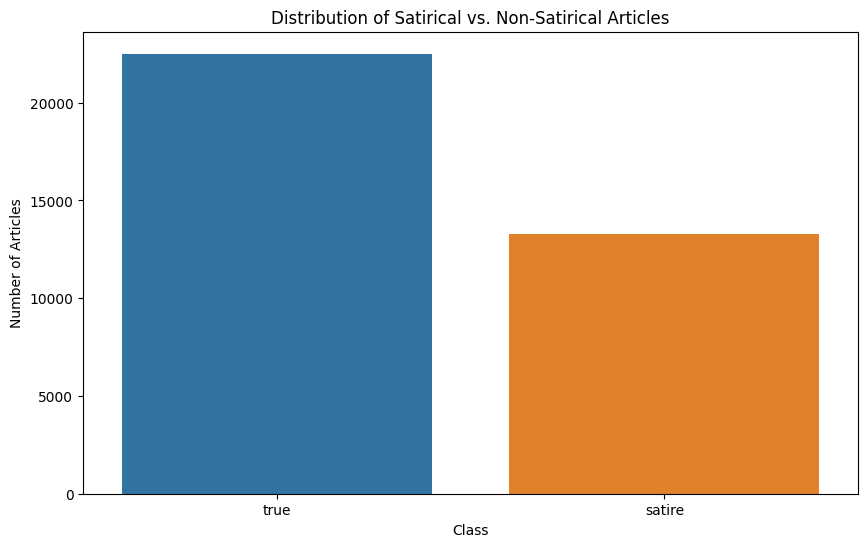

In [ ]:
# Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=training_df_extended, x='label')
plt.title('Distribution of Satirical vs. Non-Satirical Articles')
plt.ylabel('Number of Articles')
plt.xlabel('Class')
plt.show()

In [ ]:
training_df_extended.word_count.describe()

count    35814.000000
mean       367.778076
std        370.983852
min          3.000000
25%        171.000000
50%        273.000000
75%        462.000000
max       9639.000000
Name: word_count, dtype: float64

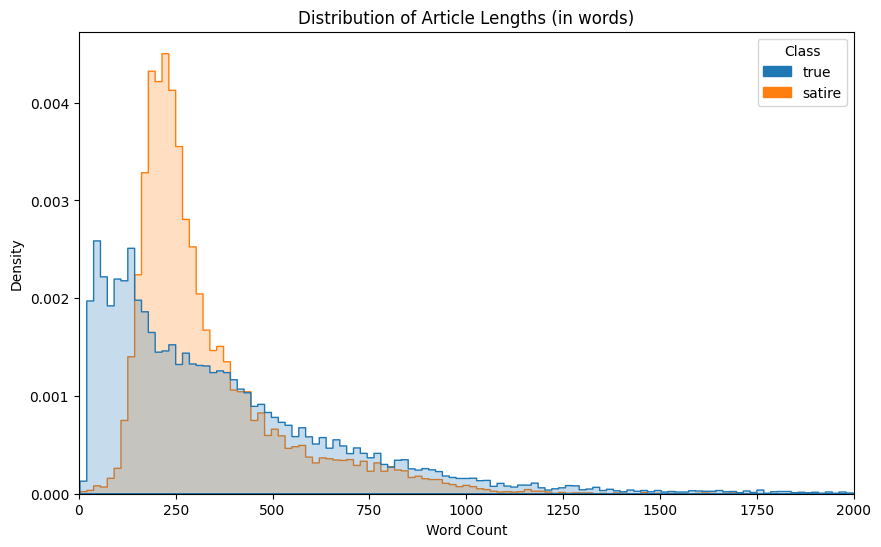

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=training_df_extended, x='word_count', hue='label', element='step', stat='density', common_norm=False, legend=False)
plt.title('Distribution of Article Lengths (in words)')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.xlim(0, 2000)  # Limiting x-axis to focus on the main content range

# Manually add legend
labels = training_df_extended['label'].unique()
colors = sns.color_palette(n_colors=len(labels))
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(labels)]
plt.legend(handles=patches, title='Class', loc='upper right')

plt.show()

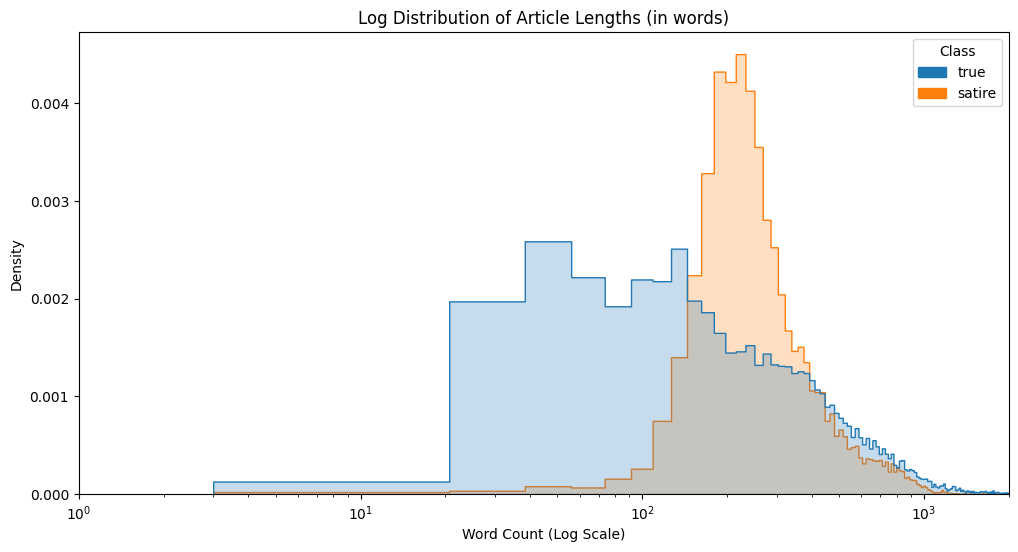

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=training_df_extended, x='word_count', hue='label', element='step', stat='density', common_norm=False, legend=False)
plt.title('Log Distribution of Article Lengths (in words)')
plt.xlabel('Word Count (Log Scale)')
plt.ylabel('Density')
plt.xscale('log')

# Since we're using a log scale, adjust the x-axis limits accordingly
plt.xlim(1, 2000)

# Manually add legend
labels = training_df_extended['label'].unique()
colors = sns.color_palette(n_colors=len(labels))
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(labels)]
plt.legend(handles=patches, title='Class', loc='upper right')

plt.show()

## Word Clouds

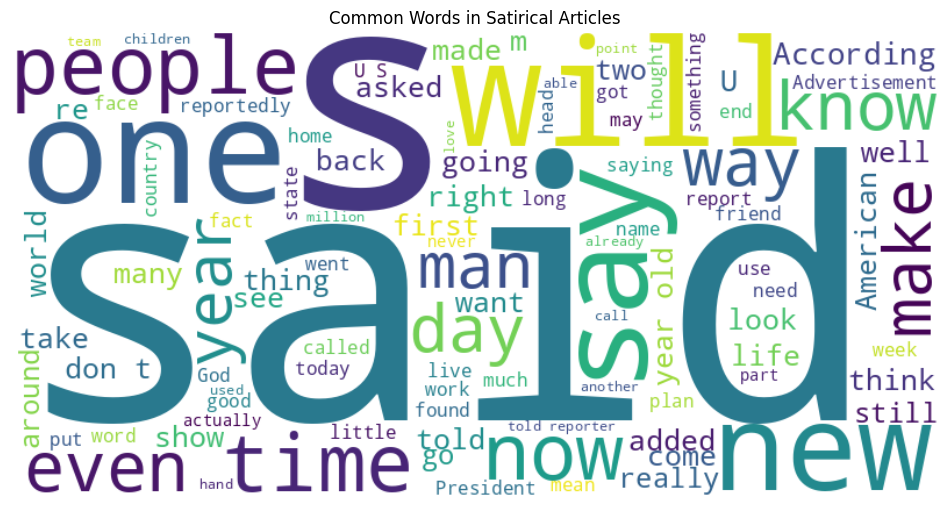

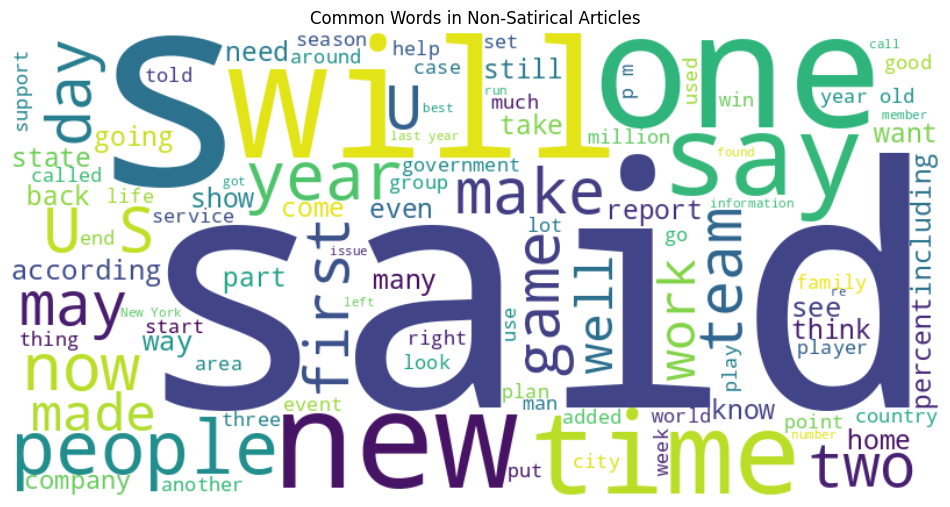

In [ ]:
# Generate word clouds for Satirical and Non-Satirical articles
def generate_wordcloud(text, title):
    wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue', width=800, height=400)
    wordcloud.generate(text)
    plt.figure(figsize=(12, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Satirical word cloud
satirical_text = ' '.join(training_df_extended[training_df_extended['label'] == 'satire']['content'])
generate_wordcloud(satirical_text, 'Common Words in Satirical Articles')

# Non-Satirical word cloud
non_satirical_text = ' '.join(training_df_extended[training_df_extended['label'] == 'true']['content'])
generate_wordcloud(non_satirical_text, 'Common Words in Non-Satirical Articles')


## Average Word Count by Class

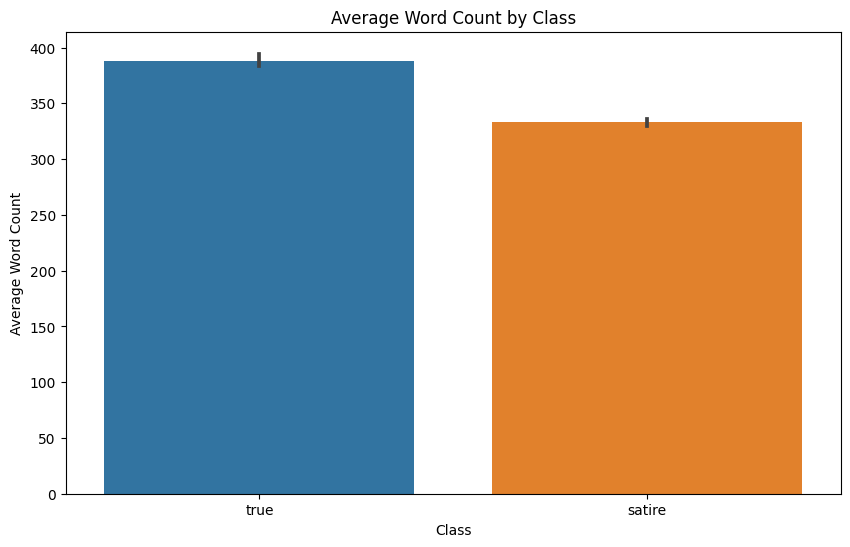

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='word_count', data=training_df_extended)
plt.title('Average Word Count by Class')
plt.ylabel('Average Word Count')
plt.xlabel('Class')
plt.show()

## Top N Frequent Words

In [ ]:
from collections import Counter

def get_top_n_words(text, n=10):
    words = ' '.join(text).split()
    word_freq = Counter(words)
    return word_freq.most_common(n)

# Top 10 frequent words for each class
top_satire = get_top_n_words(training_df_extended[training_df_extended['label'] == 'satire']['content'])
top_non_satire = get_top_n_words(training_df_extended[training_df_extended['label'] != 'satire']['content'])

print("Top words in Satirical articles:", top_satire)
print("Top words in Non-Satirical articles:", top_non_satire)

Top words in Satirical articles: [('the', 175970), ('to', 106861), ('of', 93453), ('a', 82885), ('and', 80200), ('that', 55847), ('in', 53427), ('for', 31002), ('is', 29570), ('was', 26748)]
Top words in Non-Satirical articles: [('the', 427090), ('to', 230548), ('and', 207527), ('of', 206432), ('a', 179040), ('in', 168527), ('for', 82350), ('on', 76255), ('that', 73539), ('is', 72145)]


In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Download the stop words from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_n_words(text, n=10):
    words = ' '.join(text).split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    word_freq = Counter(filtered_words)
    return word_freq.most_common(n)

# Top 10 frequent words for each class
top_satire = get_top_n_words(training_df_extended[training_df_extended['label'] == 'satire']['content'])
top_non_satire = get_top_n_words(training_df_extended[training_df_extended['label'] != 'satire']['content'])

print("Top words in Satirical articles:", top_satire)
print("Top words in Non-Satirical articles:", top_non_satire)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top words in Satirical articles: [('said', 16968), ('would', 8642), ('one', 8481), ('like', 7336), ('people', 5622), ('get', 5485), ('new', 5476), ('could', 5154), ('even', 5004), ('told', 4688)]
Top words in Non-Satirical articles: [('said', 27732), ('also', 15508), ('one', 14159), ('would', 13714), ('said.', 13065), ('two', 11580), ('first', 11379), ('—', 11002), ('people', 10812), ('new', 10693)]


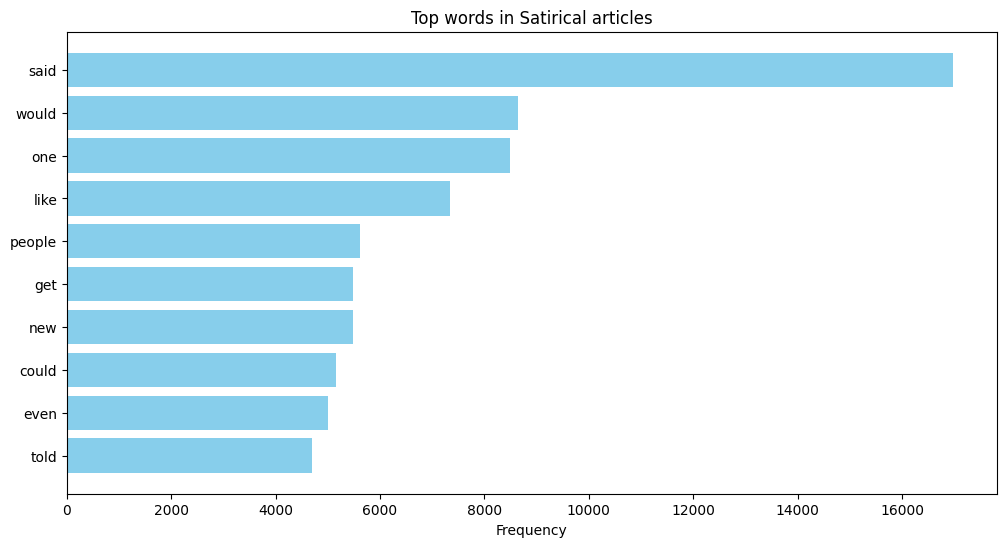

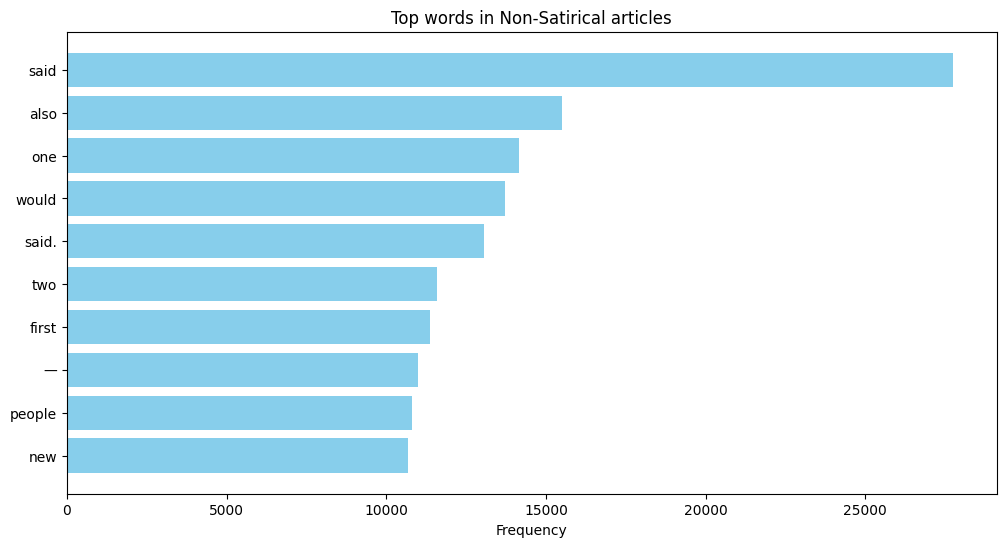

In [ ]:
def plot_top_words(top_words, title):
    words, counts = zip(*top_words)

    plt.figure(figsize=(12, 6))
    plt.barh(words, counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent words at the top
    plt.show()

# Plot the top words for Satirical articles
plot_top_words(top_satire, "Top words in Satirical articles")

# Plot the top words for Non-Satirical articles
plot_top_words(top_non_satire, "Top words in Non-Satirical articles")

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

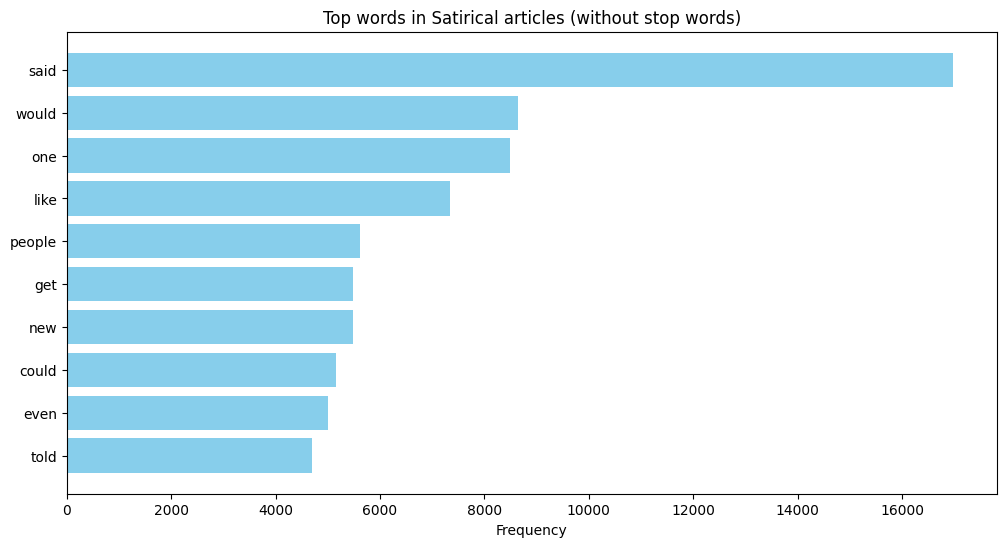

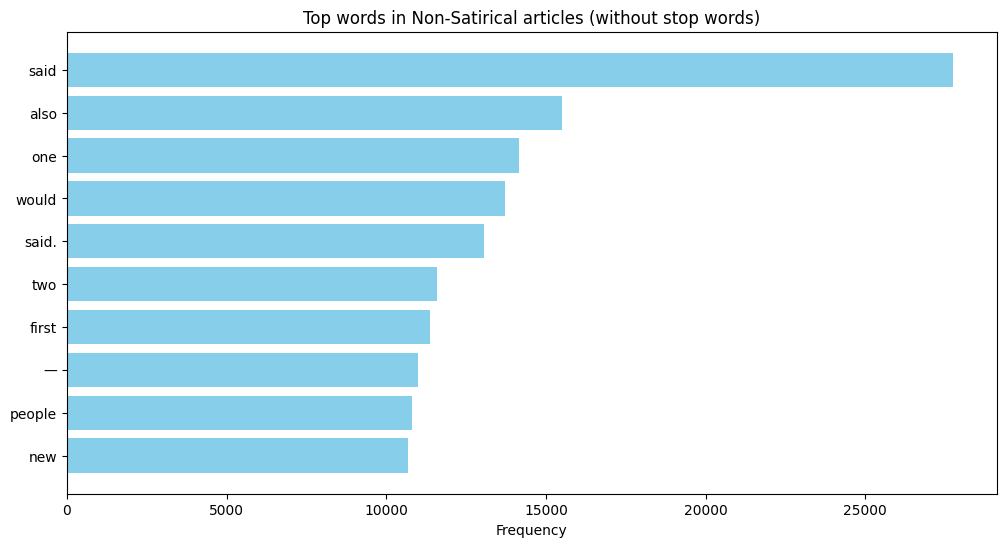

In [ ]:
def get_top_n_words(text, n=10):
    stop_words = set(stopwords.words('english'))
    words = ' '.join(text).split()
    filtered_words = [word for word in words if word.lower() not in stop_words]

    word_freq = Counter(filtered_words)
    return word_freq.most_common(n)

# Top 10 frequent words for each class after removing stop words
top_satire = get_top_n_words(training_df_extended[training_df_extended['label'] == 'satire']['content'])
top_non_satire = get_top_n_words(training_df_extended[training_df_extended['label'] != 'satire']['content'])

# Plotting
plot_top_words(top_satire, "Top words in Satirical articles (without stop words)")
plot_top_words(top_non_satire, "Top words in Non-Satirical articles (without stop words)")

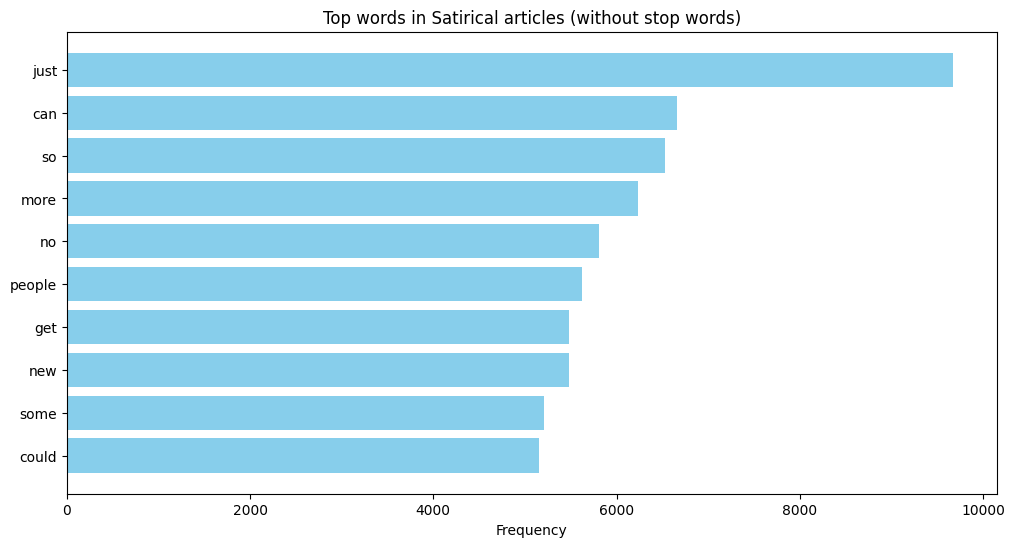

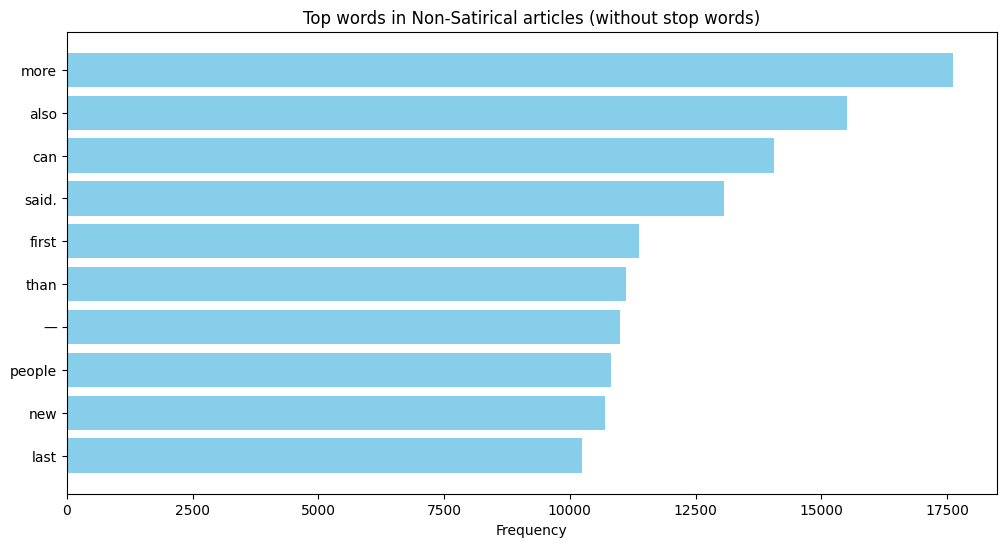

In [ ]:
# A basic list of stopwords. You can extend this as needed.
stop_words = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your",
    "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she",
    "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that",
    "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
    "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
    "the", "and", "but", "if", "or", "because", "as", "until", "while", "of",
    "at", "by", "for", "with", "about", "against", "between", "into", "through",
    "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "will","said","all","not","would","when","one","like","only"
    ,"on", "off", "over", "under", "again", "further", "then", "once","two","-"
])

def get_top_n_words(text, n=10):
    words = ' '.join(text).split()
    filtered_words = [word for word in words if word.lower() not in stop_words]

    word_freq = Counter(filtered_words)
    return word_freq.most_common(n)


# Top 10 frequent words for each class after removing stop words
top_satire = get_top_n_words(training_df_extended[training_df_extended['label'] == 'satire']['content'])
top_non_satire = get_top_n_words(training_df_extended[training_df_extended['label'] != 'satire']['content'])

# Plotting
plot_top_words(top_satire, "Top words in Satirical articles (without stop words)")
plot_top_words(top_non_satire, "Top words in Non-Satirical articles (without stop words)")


## N-gram Analysis

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram_by_class(df, label_col, text_col, ngram_range, top_n):
    classes = df[label_col].unique()
    top_ngrams_by_class = {}

    for class_label in classes:
        corpus = df[df[label_col] == class_label][text_col]
        vec = CountVectorizer(ngram_range=ngram_range, stop_words='english', lowercase=True).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        top_ngrams_by_class[class_label] = words_freq[:top_n]

    return top_ngrams_by_class

# Top 10 bi-grams for each class
top_bi_grams_by_class = get_top_ngram_by_class(training_df_extended, 'label', 'content', (2,2), 10)
for label, bi_grams in top_bi_grams_by_class.items():
    print(f"Top Bi-grams in {label} articles:", bi_grams)
    print('-' * 80)

# Top 10 tri-grams for each class
top_tri_grams_by_class = get_top_ngram_by_class(training_df_extended, 'label', 'content', (3,3), 10)
for label, tri_grams in top_tri_grams_by_class.items():
    print(f"Top Tri-grams in {label} articles:", tri_grams)
    print('-' * 80)


Top Bi-grams in true articles: [('year old', 3858), ('new york', 3044), ('united states', 2416), ('partly cloudy', 1766), ('donald trump', 1640), ('chance showers', 1499), ('white house', 1444), ('showers thunderstorms', 1444), ('prime minister', 1334), ('percent chance', 1310)]
--------------------------------------------------------------------------------
Top Bi-grams in satire articles: [('year old', 2346), ('told reporters', 1628), ('united states', 1253), ('new york', 1222), ('press time', 965), ('sources confirmed', 943), ('white house', 935), ('president obama', 850), ('donald trump', 808), ('don know', 640)]
--------------------------------------------------------------------------------
Top Tri-grams in true articles: [('chance showers thunderstorms', 1282), ('percent chance showers', 1224), ('president donald trump', 1037), ('10 15 mph', 695), ('pic twitter com', 652), ('winds 10 15', 619), ('showers thunderstorms highs', 613), ('night partly cloudy', 612), ('lows mid 70s', 

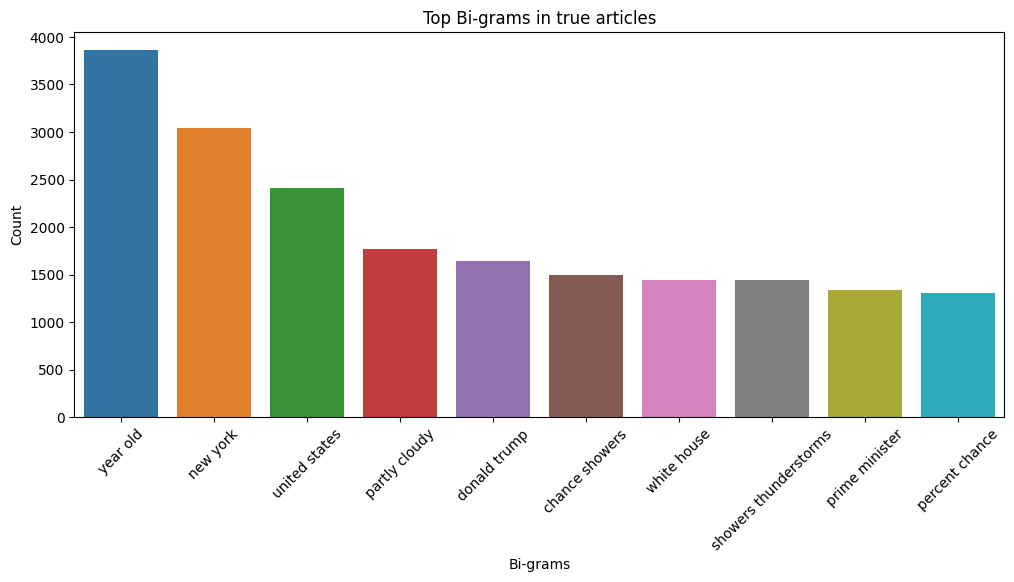

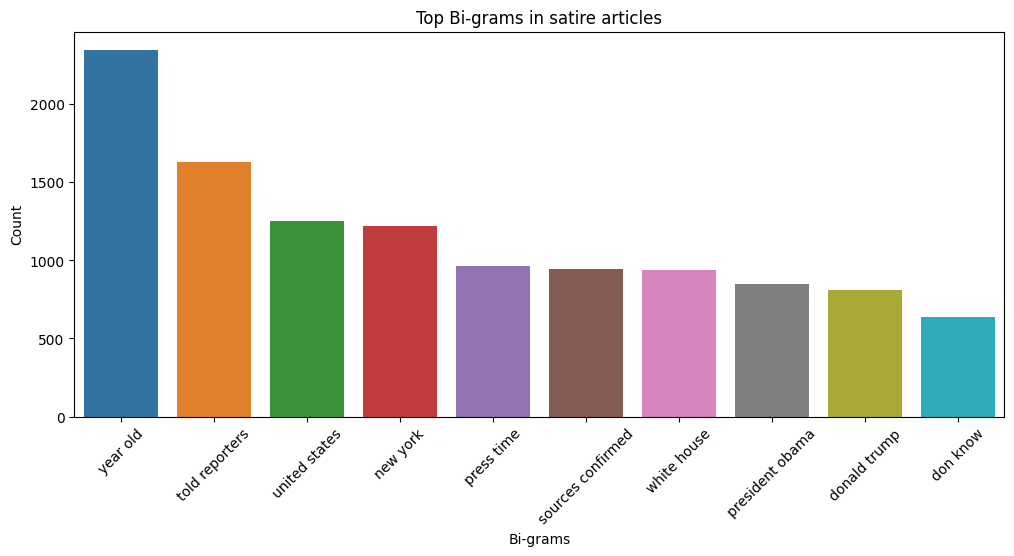

In [ ]:
def plot_ngrams(ngrams_by_class, ngram_type):
    """
    Plot the top n-grams for each class.
    """
    for label, ngrams in ngrams_by_class.items():
        words, counts = zip(*ngrams)

        plt.figure(figsize=(12, 5))
        sns.barplot(x=list(words), y=list(counts))
        plt.title(f"Top {ngram_type} in {label} articles")
        plt.xticks(rotation=45)
        plt.ylabel('Count')
        plt.xlabel(f"{ngram_type}")
        plt.show()

# Visualize top bi-grams for each class
plot_ngrams(top_bi_grams_by_class, 'Bi-grams')


In [ ]:
filtered_df = training_df_extended[training_df_extended['content'].str.contains("don know", case=False, na=False)]
print(filtered_df)

            filename                                            content label  \
16234  cc-news_00421  Colorado mired in 2-game skid heading into Ari...  true   
33789  cc-news_17976  Colorado mired in 2-game skid heading into Ari...  true   
33859  cc-news_18046  Colorado mired in 2-game skid heading into Ari...  true   

       word_count sentiment  avg_sentence_length  flesch_reading_ease  \
16234         711  positive            20.022222                82.54   
33789         710  positive            20.044444                82.54   
33859         708  positive            18.000000                82.24   

                                      punctuation_counts  \
16234  {'!': 0, '"': 0, '#': 0, '$': 0, '%': 0, '&': ...   
33789  {'!': 0, '"': 0, '#': 0, '$': 0, '%': 0, '&': ...   
33859  {'!': 0, '"': 20, '#': 0, '$': 0, '%': 0, '&':...   

                                          named_entities  
16234  [Colorado, Arizona, BOULDER, Steven, Epsom, Co...  
33789  [Colorado, Arizo

In [ ]:
for index, row in filtered_df.iterrows():
    print(f"Index: {index}")
    print(row['content'])
    print("---------------------------------------------------")

Index: 16234
Colorado mired in 2-game skid heading into Arizona game
BOULDER, Colo. — Steven Montez’s remedy for soreness after a recent loss was to pour a little more salt into the wounds.
Epsom salt, more specifically — in a bath. It worked like a charm for the Colorado quarterback who absorbed some big hits in a 27-23 loss at UCLA last weekend.
Now, he’s hoping to help heal the Buffaloes (3-2, 0-2 Pac-12), who’ve dropped two straight conference games in their defence of the Pac-12 South crown.
Next up , Arizona (2-2, 0-1) and its improved defence on Saturday. The Wildcats have forced 20 three-and-outs this season. Not bad, considering the team had 30 in a dozen games a year ago.
“They’re a good defence,” Montez said. “We’re just going to do what we do on offence, and hopefully we get some things going.”
Montez and the offence remain a work in progress. He was 17 of 36 for 243 yards along with 108 yards rushing against the Bruins. He’s trying to stay in the pocket more instead of loo

## Trigrams

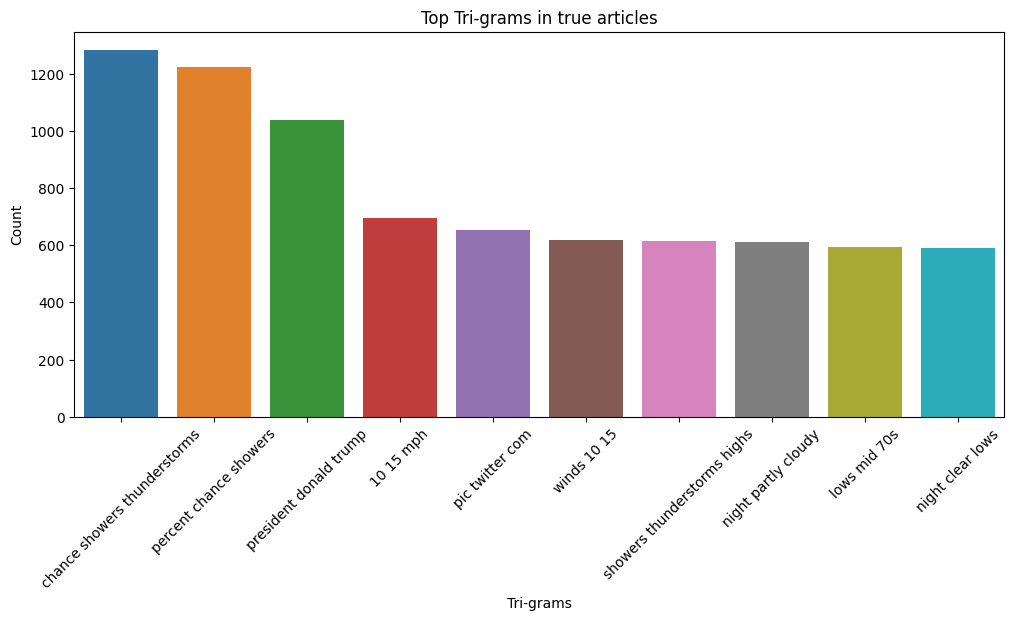

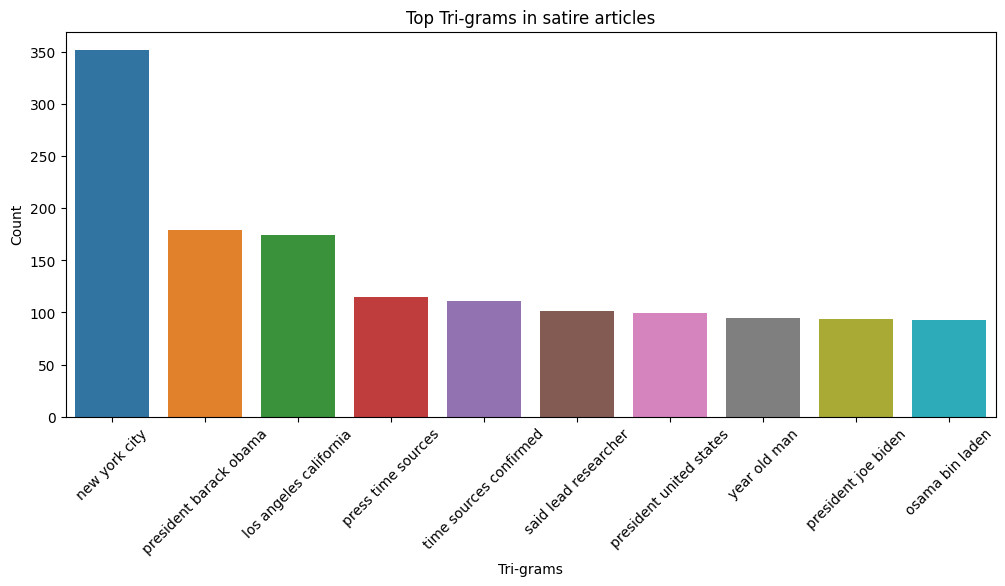

In [ ]:
# Visualize top tri-grams for each class
plot_ngrams(top_tri_grams_by_class, 'Tri-grams')

## Sentiment Analysis

In [ ]:
!pip install textblob

In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


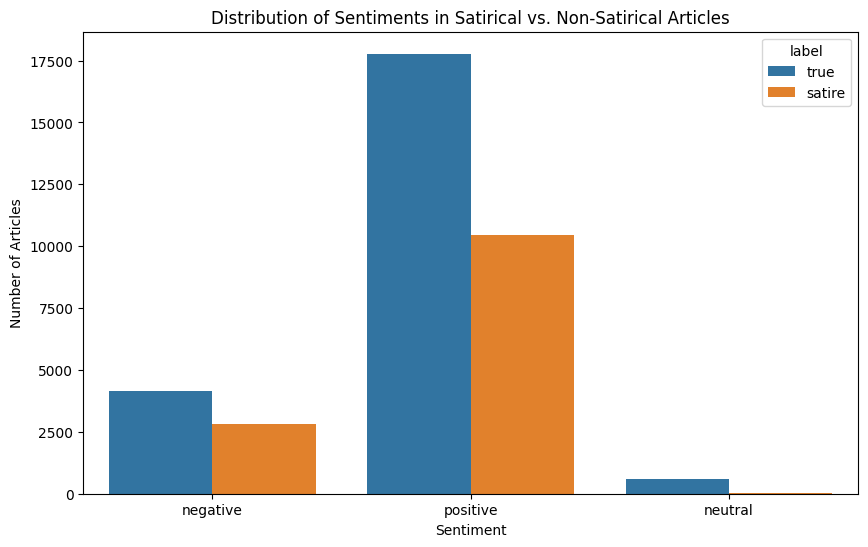

In [ ]:
from textblob import TextBlob

def get_sentiment(text):
    """
    Utility function to classify sentiment of passed text using TextBlob.
    """
    analysis = TextBlob(text)
    # Set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

# Apply the function on the 'content' column
training_df_extended['sentiment'] = training_df_extended['content'].apply(get_sentiment)

# Display the distribution of sentiments
plt.figure(figsize=(10, 6))
sns.countplot(data=training_df_extended, x='sentiment', hue='label')
plt.title('Distribution of Sentiments in Satirical vs. Non-Satirical Articles')
plt.ylabel('Number of Articles')
plt.xlabel('Sentiment')
plt.show()

<Figure size 1200x700 with 0 Axes>

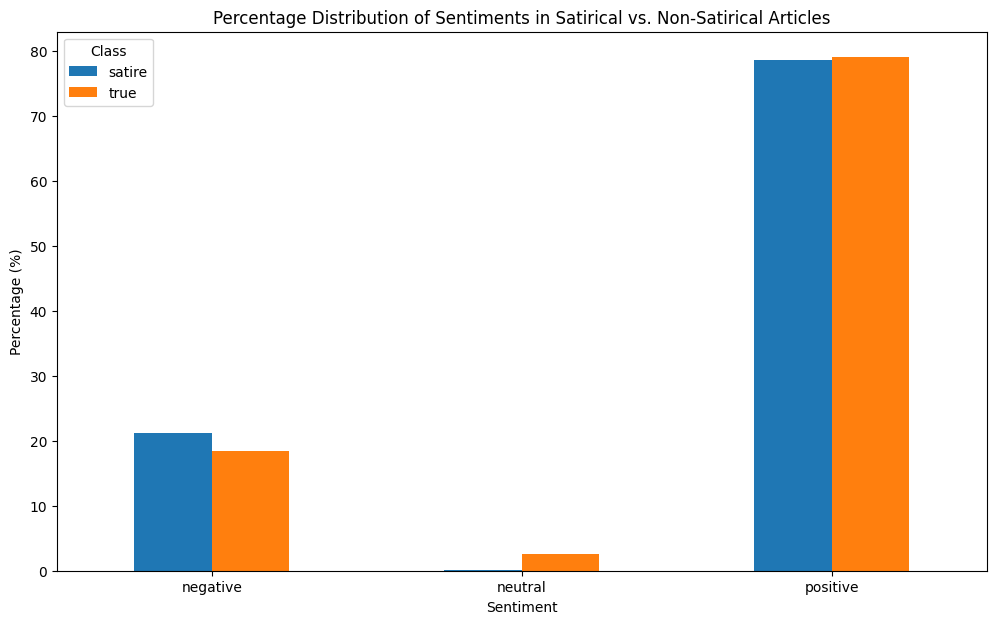

In [ ]:
# Calculate the sentiment distribution as a percentage within each class
sentiment_distribution = training_df_extended.groupby('label')['sentiment'].value_counts(normalize=True).unstack().transpose()
sentiment_distribution = sentiment_distribution * 100  # Convert to percentages

# Plot
plt.figure(figsize=(12, 7))
sentiment_distribution.plot(kind='bar', stacked=False, figsize=(12, 7))
plt.title('Percentage Distribution of Sentiments in Satirical vs. Non-Satirical Articles')
plt.ylabel('Percentage (%)')
plt.xlabel('Sentiment')
plt.xticks(rotation=0)
plt.legend(title='Class')
plt.show()

## Average Sentence Length

In [ ]:
import nltk
nltk.download('punkt')  # Download the Punkt Tokenizer Models

from nltk.tokenize import sent_tokenize, word_tokenize

def avg_sentence_length(text):
    """Compute the average sentence length of a text."""
    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return 0
    return sum(len(word_tokenize(sentence)) for sentence in sentences) / len(sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
training_df_extended['avg_sentence_length'] = training_df_extended['content'].apply(avg_sentence_length)

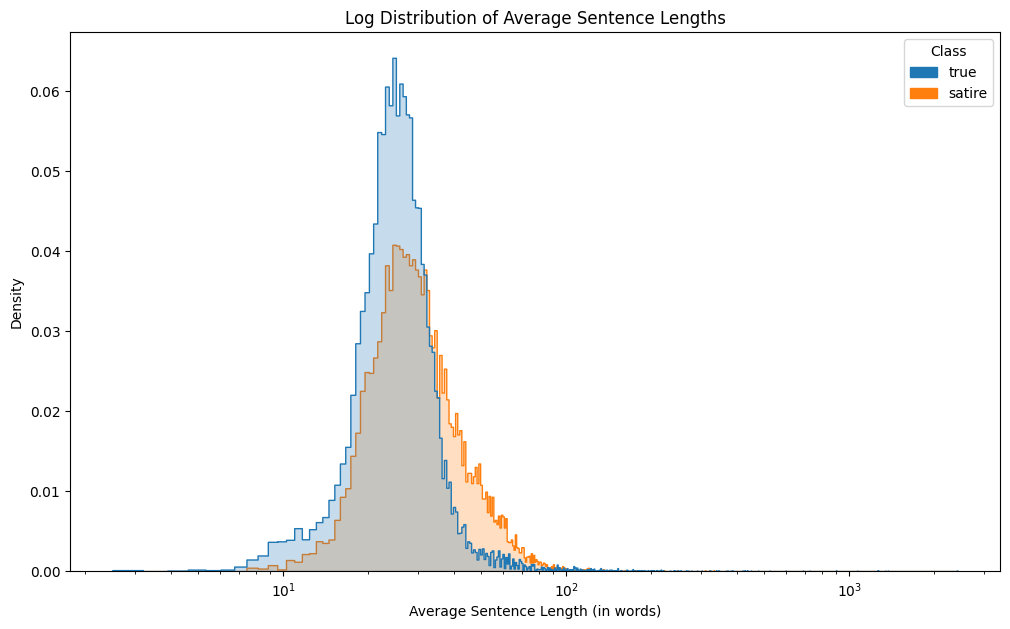

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 7))
sns.histplot(data=training_df_extended, x='avg_sentence_length', hue='label', element='step', stat='density', common_norm=False)
plt.title('Log Distribution of Average Sentence Lengths')
plt.xlabel('Average Sentence Length (in words)')
plt.ylabel('Density')
plt.xscale('log')

# Create custom legend
colors = sns.color_palette()  # Default Seaborn color palette
labels = training_df_extended['label'].unique()
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=patches, title='Class')
plt.show()

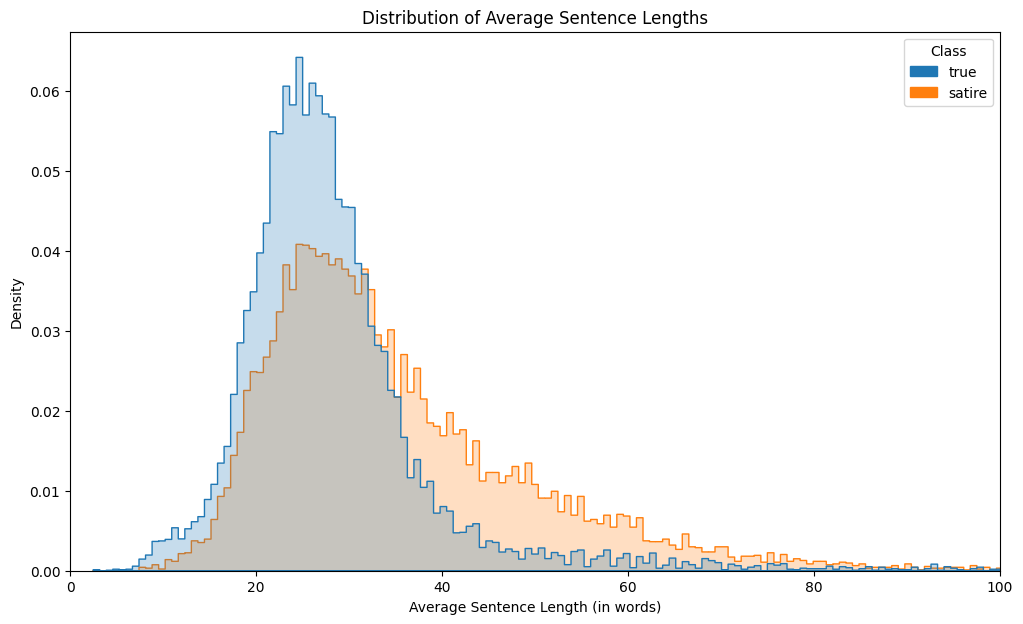

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 7))
sns.histplot(data=training_df_extended, x='avg_sentence_length', hue='label', element='step', stat='density', common_norm=False)
plt.title('Distribution of Average Sentence Lengths')
plt.xlabel('Average Sentence Length (in words)')
plt.ylabel('Density')
plt.xlim(0,100) # set x-axis limits

# Create custom legend
colors = sns.color_palette()  # Default Seaborn color palette
labels = training_df_extended['label'].unique()
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=patches, title='Class')
plt.show()

In [ ]:
# Calculate basic stats using describe()
grouped_stats = training_df_extended.groupby('label')['avg_sentence_length'].describe()
selected_stats = grouped_stats[['mean', 'std', 'min', 'max']]

# Calculate the mode separately
mode_stats = training_df_extended.groupby('label')['avg_sentence_length'].apply(lambda x: x.mode().iloc[0])
mode_stats.name = 'mode'

# Combine the stats
final_stats = pd.concat([selected_stats, mode_stats], axis=1)
final_stats = final_stats[['mean', 'mode', 'std', 'min', 'max']]

# Round to 1 decimal point
rounded_stats = final_stats.round(1)
print(rounded_stats)

        mean  mode   std  min     max
label                                
satire  35.4  32.0  15.9  7.5   332.0
true    30.4  26.0  39.5  2.5  2418.0


## Readability Score

#### Readability Score: Flesch Reading Ease score. The Flesch Reading Ease score is a widely-used metric for assessing the readability of English text. Scores typically range between 0 and 100, with higher scores indicating more straightforward and easier-to-read text.

In [ ]:
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.8 MB/s eta 0:00:00


In [ ]:
import textstat

# Calculate the Flesch Reading Ease score for each article
training_df_extended['flesch_reading_ease'] = training_df_extended['content'].apply(textstat.flesch_reading_ease)

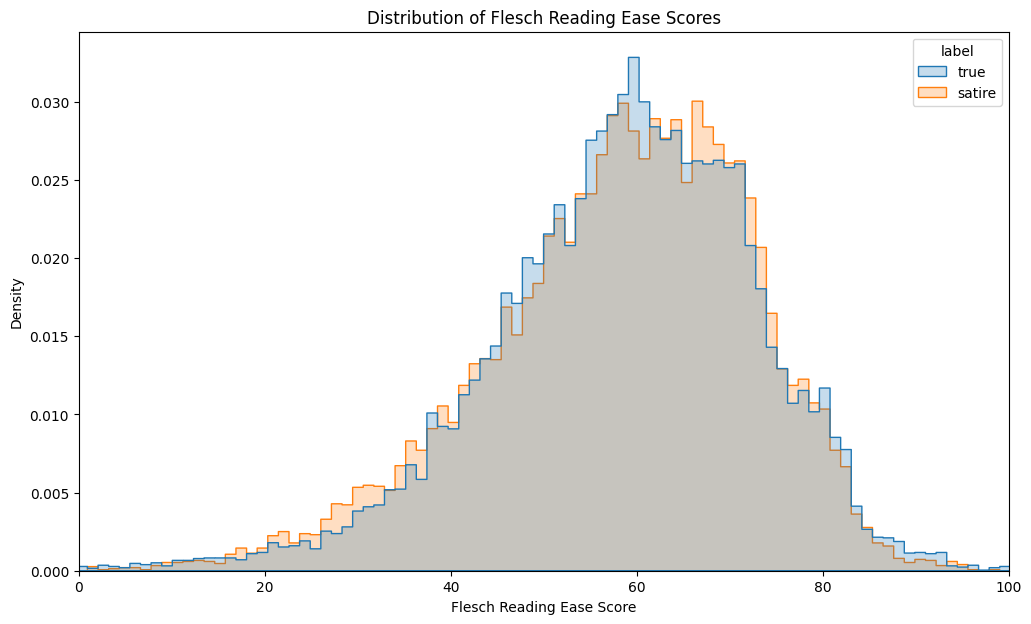

In [ ]:
plt.figure(figsize=(12, 7))
sns.histplot(data=training_df_extended, x='flesch_reading_ease', hue='label', element='step', stat='density', common_norm=False)
plt.title('Distribution of Flesch Reading Ease Scores')
plt.xlabel('Flesch Reading Ease Score')
plt.ylabel('Density')
plt.xlim(0, 100)
plt.show()

In [ ]:
# Calculate basic stats using describe()
grouped_stats = training_df_extended.groupby('label')['flesch_reading_ease'].describe()
selected_stats = grouped_stats[['mean', 'std', 'min', 'max']]

# Calculate the mode separately
mode_stats = training_df_extended.groupby('label')['flesch_reading_ease'].apply(lambda x: x.mode().iloc[0])
mode_stats.name = 'mode'

# Combine the stats and re-order the columns to have 'mode' next to 'mean'
final_stats = pd.concat([selected_stats, mode_stats], axis=1)
final_stats = final_stats[['mean', 'mode', 'std', 'min', 'max']]

# Round to 1 decimal point
rounded_stats = final_stats.round(1)
print(rounded_stats)

        mean  mode   std    min    max
label                                 
satire  58.0  67.8  14.8  -83.5  102.4
true    57.8  59.6  19.0 -829.5  111.6


## Punctuation Usage

In [ ]:
import string

# Initialize a dictionary with punctuation marks as keys
punctuation_dict = {punct: 0 for punct in string.punctuation}

def count_punctuation(text):
    """Count the occurrences of punctuation marks in a text."""
    return {punct: text.count(punct) for punct in string.punctuation}

# Apply the function to the 'content' column
training_df_extended['punctuation_counts'] = training_df_extended['content'].apply(count_punctuation)

In [ ]:
from collections import Counter

# Use a Counter to sum up the punctuation counts for the entire dataset
overall_punctuation_counts = Counter()

for punctuation_count in training_df_extended['punctuation_counts']:
    overall_punctuation_counts.update(punctuation_count)

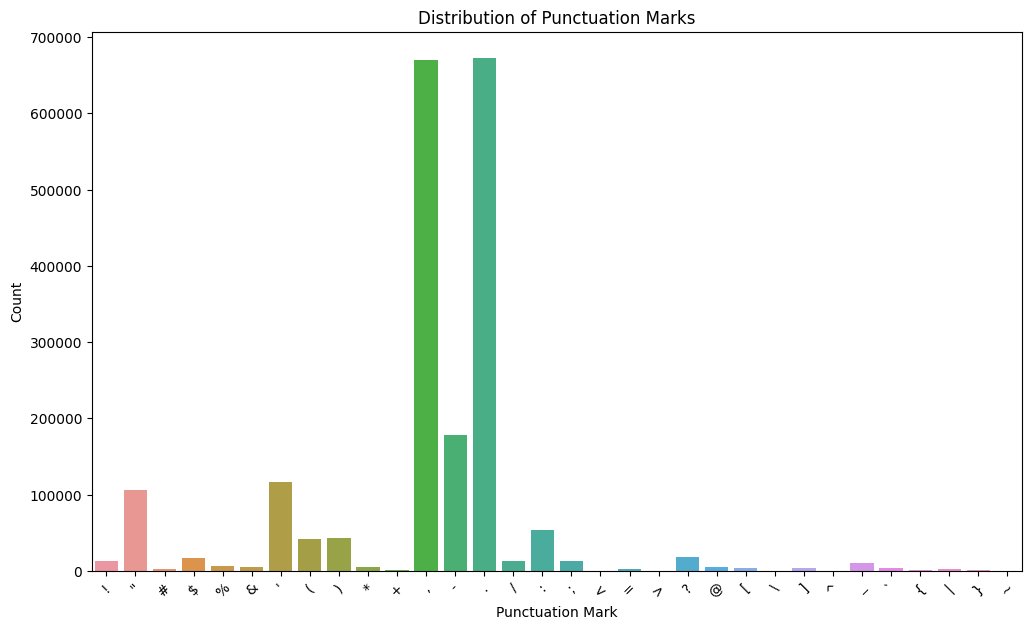

In [ ]:
plt.figure(figsize=(12, 7))
sns.barplot(x=list(overall_punctuation_counts.keys()), y=list(overall_punctuation_counts.values()))
plt.title('Distribution of Punctuation Marks')
plt.xlabel('Punctuation Mark')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Initialize a dictionary to hold the summed punctuation counts for each label
grouped_punctuation_counts = {label: Counter() for label in training_df_extended['label'].unique()}

# Iterate through the dataset and update the counts for each label
for _, row in training_df_extended.iterrows():
    grouped_punctuation_counts[row['label']].update(row['punctuation_counts'])

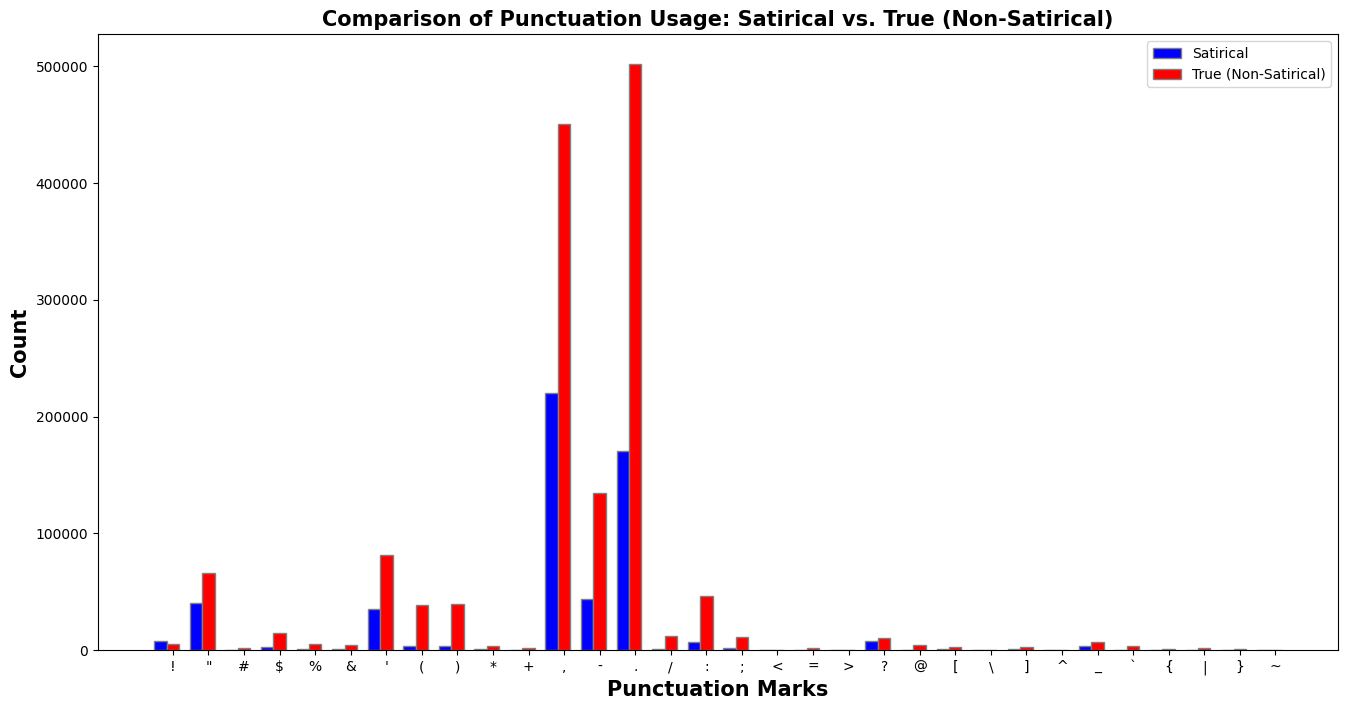

In [ ]:
# Extract data for plotting
labels = list(grouped_punctuation_counts.keys())
punctuation_marks = list(string.punctuation)
values_satirical = [grouped_punctuation_counts['satire'].get(punct, 0) for punct in punctuation_marks]
values_true = [grouped_punctuation_counts['true'].get(punct, 0) for punct in punctuation_marks]

# Define bar width for side-by-side bars
bar_width = 0.35
r1 = np.arange(len(punctuation_marks))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(16, 8))
plt.bar(r1, values_satirical, color='blue', width=bar_width, edgecolor='grey', label='Satirical')
plt.bar(r2, values_true, color='red', width=bar_width, edgecolor='grey', label='True (Non-Satirical)')

# Add labels and title
plt.xlabel('Punctuation Marks', fontweight='bold', fontsize=15)
plt.xticks([r + bar_width for r in range(len(punctuation_marks))], punctuation_marks)
plt.ylabel('Count', fontweight='bold', fontsize=15)
plt.title('Comparison of Punctuation Usage: Satirical vs. True (Non-Satirical)', fontweight='bold', fontsize=15)
plt.legend()

plt.show()

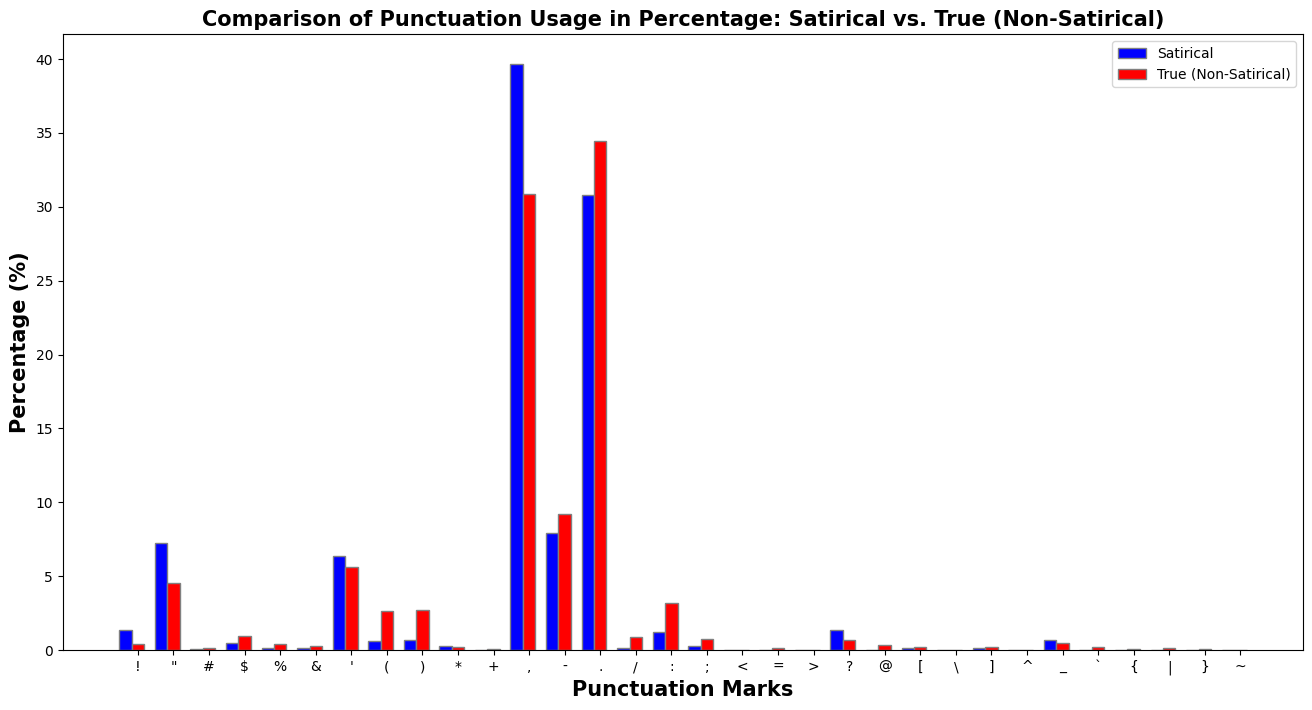

In [ ]:
# Calculate the total punctuation count for each class
total_satire = sum(values_satirical)
total_true = sum(values_true)

# Compute the percentage usage for each punctuation mark
percentage_satirical = [count / total_satire * 100 for count in values_satirical]
percentage_true = [count / total_true * 100 for count in values_true]

# Plot
plt.figure(figsize=(16, 8))
plt.bar(r1, percentage_satirical, color='blue', width=bar_width, edgecolor='grey', label='Satirical')
plt.bar(r2, percentage_true, color='red', width=bar_width, edgecolor='grey', label='True (Non-Satirical)')

# Add labels and title
plt.xlabel('Punctuation Marks', fontweight='bold', fontsize=15)
plt.xticks([r + bar_width for r in range(len(punctuation_marks))], punctuation_marks)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=15)
plt.title('Comparison of Punctuation Usage in Percentage: Satirical vs. True (Non-Satirical)', fontweight='bold', fontsize=15)
plt.legend()

plt.show()

## Named Entity Recognition (NER)

### Use NER to extract named entities (like people, organizations, and places) and see if there are specific entities that are more prevalent in satirical vs. non-satirical articles.

In [ ]:
import nltk
from nltk.chunk import conlltags2tree, tree2conlltags
from collections import defaultdict

# Ensure the necessary NLTK datasets/models are downloaded
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

def extract_named_entities(text):
    """Extract and return named entities from a text."""
    chunks = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(text)))
    named_entities = [chunk[0][0] for chunk in chunks if isinstance(chunk, nltk.Tree)]
    return named_entities

# Extract named entities for each article
training_df_extended['named_entities'] = training_df_extended['content'].apply(extract_named_entities)

# Analyze the most common named entities for each class
def top_entities(df, label, top_n=10):
    entities = defaultdict(int)
    subset = df[df['label'] == label]
    for named_entities in subset['named_entities']:
        for ne in named_entities:
            entities[ne] += 1
    return sorted(entities.items(), key=lambda x: x[1], reverse=True)[:top_n]

print("Top Named Entities in Satirical Articles:", top_entities(training_df_extended, 'satire'))
print("Top Named Entities in True Articles:", top_entities(training_df_extended, 'true'))


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Top Named Entities in Satirical Articles: [('American', 2299), ('New', 2260), ('Obama', 2102), ('Trump', 1801), ('Mr.', 1757), ('U.S.', 1621), ('United', 1497), ('America', 1281), ('White', 1136), ('John', 1093)]
Top Named Entities in True Articles: [('U.S.', 5731), ('New', 5454), ('Trump', 5409), ('United', 3576), ('US', 3572), ('North', 3386), ('South', 3288), ('China', 3072), ('AP', 2943), ('American', 2598)]


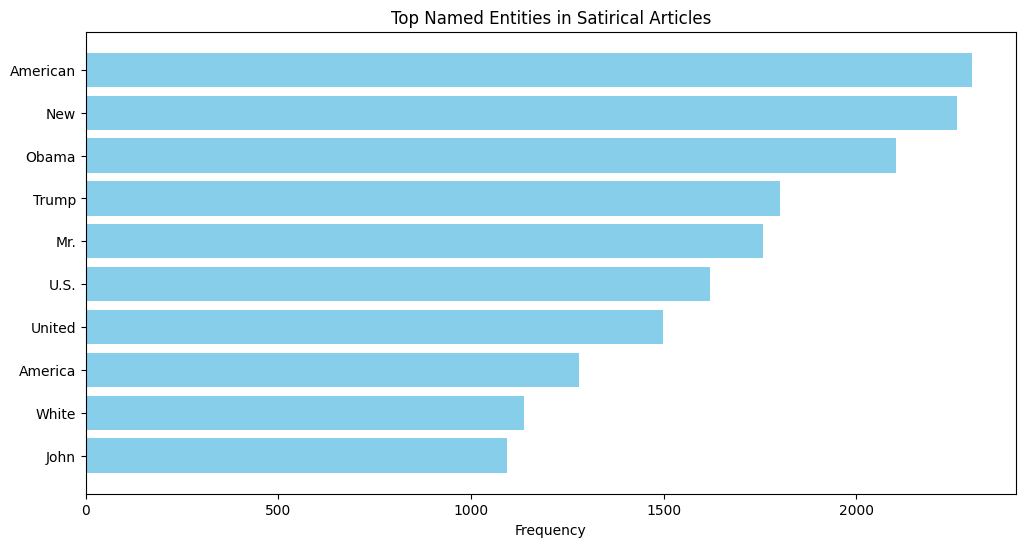

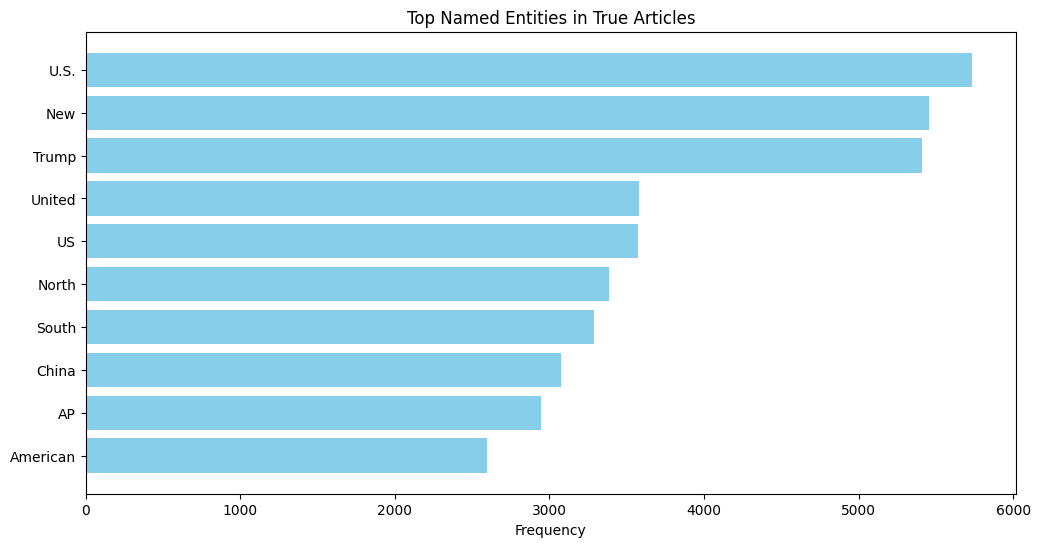

In [ ]:
def plot_top_entities(entities, title):
    """Plot the top named entities."""
    entity_names, counts = zip(*entities)

    plt.figure(figsize=(12, 6))
    plt.barh(entity_names, counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()  # To display the most frequent entity at the top
    plt.show()

# Get top named entities for both classes
top_satire_entities = top_entities(training_df_extended, 'satire')
top_true_entities = top_entities(training_df_extended, 'true')

# Plot the top named entities for Satirical articles
plot_top_entities(top_satire_entities, "Top Named Entities in Satirical Articles")

# Plot the top named entities for True articles
plot_top_entities(top_true_entities, "Top Named Entities in True Articles")



## Topic Modeling

###Use techniques like Latent Dirichlet Allocation (LDA) to identify common topics in both types of articles. This can help you understand the common themes/topics that are covered in satirical vs. non-satirical articles.


In [ ]:
!pip install gensim

In [ ]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords

nltk.download('stopwords')

# Prepare data for LDA
texts = training_df_extended['content'].apply(lambda x: [word for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words('english')])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Create and train the LDA model
lda = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(0, '0.007*"said" + 0.006*"new" + 0.006*"market" + 0.006*"company" + 0.005*"also"')
(1, '0.009*"game" + 0.007*"season" + 0.007*"team" + 0.007*"first" + 0.005*"said"')
(2, '0.017*"said" + 0.008*"trump" + 0.008*"police" + 0.007*"president" + 0.004*"state"')
(3, '0.007*"said" + 0.007*"one" + 0.007*"like" + 0.005*"time" + 0.004*"new"')
(4, '0.008*"school" + 0.007*"said" + 0.006*"health" + 0.005*"people" + 0.005*"water"')


## Most Common Adjectives and Verbs

###Inspect the most common adjectives and verbs in each type of article. Satirical articles might use more exaggerated language, which could reflect in the choice of adjectives and verbs.

In [ ]:
def top_pos_tags(df, label, pos_list, top_n=10):
    pos_freq = defaultdict(int)
    subset = df[df['label'] == label]
    for content in subset['content']:
        tokens = nltk.word_tokenize(content)
        for word, pos in nltk.pos_tag(tokens):
            if pos in pos_list:
                pos_freq[word] += 1
    return sorted(pos_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]

print("Top Adjectives in Satirical Articles:", top_pos_tags(training_df_extended, 'satire', ['JJ']))
print("Top Adjectives in True Articles:", top_pos_tags(training_df_extended, 'true', ['JJ']))
print("Top Verbs in Satirical Articles:", top_pos_tags(training_df_extended, 'satire', ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']))
print("Top Verbs in True Articles:", top_pos_tags(training_df_extended, 'true', ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']))


Top Adjectives in Satirical Articles: [('’', 6826), ('new', 5607), ('“', 4540), ('s', 4504), ('other', 4469), ('many', 3212), ('”', 3114), ('last', 3018), ('first', 3016), ('good', 2556)]
Top Adjectives in True Articles: [('new', 10939), ('other', 10423), ('last', 10367), ('first', 10130), ('s', 8694), ('’', 7959), ('many', 5563), ('“', 5533), ('good', 4751), ('such', 4350)]
Top Verbs in Satirical Articles: [('is', 30870), ('was', 27459), ('be', 21671), ('said', 21252), ('’', 20064), ('have', 19244), ('has', 15782), ('are', 14308), ('“', 11667), ('had', 11431)]
Top Verbs in True Articles: [('is', 73763), ('was', 54038), ('said', 45210), ('be', 38996), ('are', 35638), ('have', 35598), ('has', 33303), ('’', 23349), ('s', 21711), ('had', 19263)]


# TF-IDF Analysis

### Use Term Frequency-Inverse Document Frequency (TF-IDF) to find important terms for each class. This can help identify keywords that are important for satirical or non-satirical content.

In [ ]:
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import TfidfModel

def compute_tfidf_for_label(df, label):
    """Compute TF-IDF scores for a specific label."""
    # Filter the dataframe by the label and prepare texts
    texts_label = df[df['label'] == label]['content'].apply(lambda x: [word for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words('english')])
    dictionary_label = corpora.Dictionary(texts_label)
    corpus_label = [dictionary_label.doc2bow(text) for text in texts_label]

    # Compute TF-IDF
    tfidf = TfidfModel(corpus_label)
    tfidf_corpus_label = tfidf[corpus_label]

    return tfidf_corpus_label, dictionary_label

def top_terms_for_label(tfidf_corpus, dictionary, top_n=10):
    """Extract the top N terms based on their TF-IDF scores."""
    term_weights = defaultdict(float)
    for doc in tfidf_corpus:
        for term_id, weight in doc:
            term_weights[dictionary[term_id]] += weight
    return sorted(term_weights.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Compute TF-IDF scores for each class
tfidf_satire, dict_satire = compute_tfidf_for_label(training_df_extended, 'satire')
tfidf_true, dict_true = compute_tfidf_for_label(training_df_extended, 'true')

# Extract top terms for each class
top_terms_satire = top_terms_for_label(tfidf_satire, dict_satire)
top_terms_true = top_terms_for_label(tfidf_true, dict_true)

print("Top terms for Satirical articles based on TF-IDF:")
print(top_terms_satire)
print("\nTop terms for True articles based on TF-IDF:")
print(top_terms_true)

Top terms for Satirical articles based on TF-IDF:
[('trump', 130.61778551320015), ('new', 121.38451239620102), ('president', 118.07664890081206), ('people', 114.77226245545036), ('would', 111.28235003759545), ('man', 104.70899911583696), ('like', 103.23113876694401), ('obama', 102.61442422024106), ('one', 101.40585717534526), ('time', 99.27015143241657)]

Top terms for True articles based on TF-IDF:
[('said', 266.09861094069106), ('police', 202.657545948392), ('trump', 181.0342134338407), ('new', 175.6216006330225), ('people', 159.1830949584885), ('percent', 157.4906235710098), ('us', 155.6485871818878), ('year', 148.32797744873605), ('news', 146.51883788504225), ('would', 144.09818200768362)]


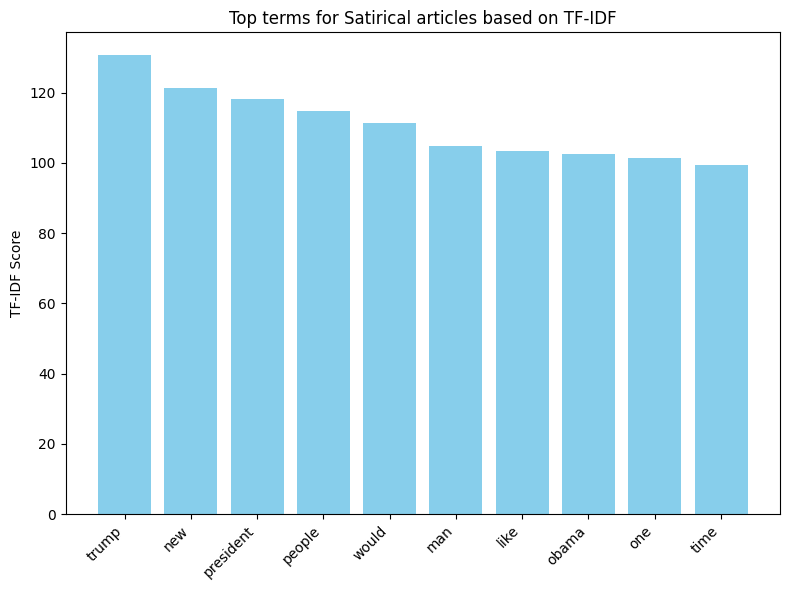

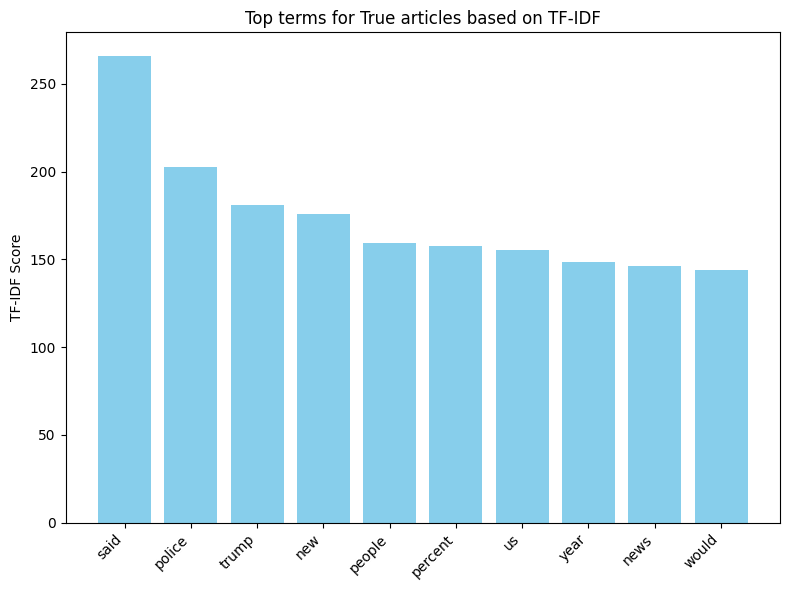

In [ ]:
import matplotlib.pyplot as plt

def plot_top_terms(top_terms, title):
    terms, scores = zip(*top_terms)

    plt.figure(figsize=(8, 6))
    plt.bar(terms, scores, color='skyblue')
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('TF-IDF Score')
    plt.tight_layout()
    plt.show()

# Assuming you've already computed top_terms_satire and top_terms_true:
plot_top_terms(top_terms_satire, "Top terms for Satirical articles based on TF-IDF")
plot_top_terms(top_terms_true, "Top terms for True articles based on TF-IDF")